## NCEM IO 

In [168]:
import glob
from stempy import io, image
import numpy as np
from PIL import Image
from mpi4py import MPI
import sys
width = 513
height = 513

In [144]:
files = glob.glob('/global/cscratch1/sd/cjh1/scan_0000000308/*.dat')
world_size=60
print(len(files))

164


In [145]:
def file_on_rank(rank):
    files_rank=[]
    files_per_rank = len(files) // world_size
    left_over = len(files) % world_size
    if rank < left_over:
        offset = rank*(files_per_rank+1)
        files_rank = files[offset:offset+files_per_rank+1]
    else:
        offset = rank*files_per_rank+left_over
        files_rank = files[offset:offset+files_per_rank]
    return files_rank

In [146]:
files_ranks=[]
for i in range(60):
    files_ranks.append(file_on_rank(i))

In [8]:
%%time
for i in range (60):
    reader = io.reader(files_ranks[i], version=io.FileVersion.VERSION2)
    local_stem = image.create_stem_image(reader, width, height, 40, 288)

CPU times: user 1min 13s, sys: 2min 17s, total: 3min 31s
Wall time: 3min 25s


In [147]:
%%time
reader = io.reader(files_ranks[51], version=io.FileVersion.VERSION2)

CPU times: user 825 µs, sys: 1.45 ms, total: 2.27 ms
Wall time: 62.4 ms


In [148]:
%%debug
local_stem = image.create_stem_image(reader, width, height, 40, 288)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()



ipdb>  s


--Call--
> /global/homes/c/cjh1/4dstem/build/stempy/lib/stempy/image/__init__.py(5)create_stem_image()
      3 from collections import namedtuple
      4 
----> 5 def create_stem_image(reader, width, height,  inner_radius,
      6                       outer_radius, read_threads=2):
      7     img =  _image.create_stem_image(reader.begin(), reader.end(),



ipdb>  s


> /global/homes/c/cjh1/4dstem/build/stempy/lib/stempy/image/__init__.py(7)create_stem_image()
      5 def create_stem_image(reader, width, height,  inner_radius,
      6                       outer_radius, read_threads=2):
----> 7     img =  _image.create_stem_image(reader.begin(), reader.end(),
      8                                     width, height,  inner_radius, outer_radius, read_threads)
      9 



ipdb>  c


In [176]:
%%time
reader = io.reader(files_ranks[11], version=io.FileVersion.VERSION2)
local_stem = image.create_stem_image(reader, width, height, 40, 288)

CPU times: user 1.23 s, sys: 3.27 s, total: 4.5 s
Wall time: 3.84 s


In [178]:
%%time
reader = io.reader(files_ranks[21], version=io.FileVersion.VERSION2)
r=reader.read()
r2=reader.read()
r3=reader.read()

CPU times: user 569 µs, sys: 3.66 s, total: 3.66 s
Wall time: 3.9 s


In [150]:
r.data.nbytes

1061683200

In [165]:
print(r.data.shape)
print(r2.data.shape)
print(r3.data.shape)

(1600, 576, 576)
(1600, 576, 576)
(1600, 576, 576)


In [166]:
from pympler import asizeof
import copy
print(r.header.images_in_block)
print(r.header.columns)
print(r.header.version)
print(local_stem.bright.shape)
print(local_stem.dark.shape)

1600
576
2
(513, 513)
(513, 513)


In [167]:
r.data[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

## Benchmarking on Cori Burst Buffer and CSCRATCH, June 26 2019

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,os
%matplotlib inline

In [170]:
bb_log=pd.read_csv('/global/cscratch1/sd/jialin/ncem_io/bb_io.csv',delimiter='\t',index_col=0)
cscratch_log=pd.read_csv('/global/cscratch1/sd/jialin/ncem_io/cscratch_io.csv',delimiter='\t',index_col=0)

In [171]:
bb_bw=1061683204/bb_log.mean(axis=1)/1024/1024
bb_bw_std=(1061683204/bb_log/1024/1024).std(axis=1)
cs_bw=1061683204/cscratch_log.mean(axis=1)/1024/1024
cs_bw_std=(1061683204/cscratch_log/1024/1024).std(axis=1)

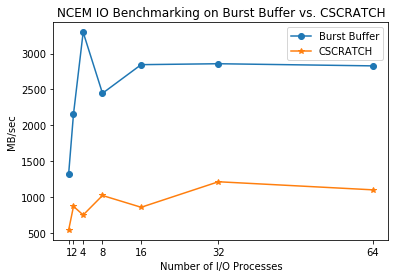

In [172]:
#plt.errorbar(bb_log.index, y=bb_bw,yerr=bb_bw_std,ecolor='green',ls='--')
plt.plot(bb_bw,marker='o',label='Burst Buffer')
plt.plot(cs_bw,marker='*',label='CSCRATCH')
plt.xticks(bb_log.index,bb_log.index)
plt.xlabel('Number of I/O Processes')
plt.ylabel('MB/sec')
plt.title('NCEM IO Benchmarking on Burst Buffer vs. CSCRATCH')
plt.legend()

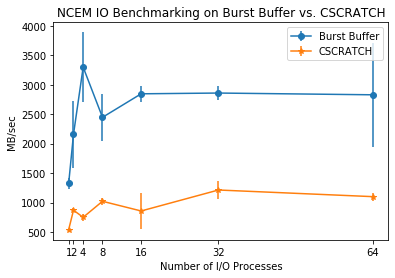

In [173]:
plt.errorbar(bb_log.index, y=bb_bw,yerr=bb_bw_std,marker='o',label='Burst Buffer')
plt.errorbar(cscratch_log.index, y=cs_bw,yerr=cs_bw_std,marker='*',label='CSCRATCH')
#plt.plot(bb_bw,marker='o',label='Burst Buffer')
#plt.plot(cs_bw,marker='*',label='CSCRATCH')
plt.xticks(bb_log.index,bb_log.index)
plt.xlabel('Number of I/O Processes')
plt.ylabel('MB/sec')
plt.title('NCEM IO Benchmarking on Burst Buffer vs. CSCRATCH')
plt.legend()

In [174]:
bb_bw.max()

3296.9215831346232

In [175]:
cs_bw.max()

1213.974924151683

In [179]:
bb_bw.max()/bb_bw.min()

2.4864964604901263